# Apply a Simple Bag-of-Words Approach

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
corpus = [
    '2 cups of flour',
    'replace the flour',
    'replace the keyboard in 2 minutes',
    'do you prefer Windows or Mac',
    'the Mac has the most noisy keyboard',
]
X = vectorizer.fit_transform(corpus)
X.todense()

matrix([[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0]])

# classification

The simplified brown corpus is available in the data folder of this github repository


In [32]:
import pandas as pd
df = pd.read_csv("../data/brown_corpus_extract_humor_science_fiction.csv")
df.shape

(2001, 2)

In [33]:
df.head()

topic                                               text
0            humor  They were always leaping to light cigarettes ,...
1  science_fiction  No , the fish could eat their bodies for all t...
2  science_fiction  Fighting pleasure itself , he begged B'dikkat ...
3  science_fiction            that is all I can tell you about them .
4            humor  `` That's one thing I've never done '' , she s...

## Load spacy 


In [34]:
import spacy
nlp = spacy.load("en_core_web_sm")

Define a function that 

- removes stopwords
- removes punctuation signs
- lemmatizes the text


In [35]:
def preprocess(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not (token.is_stop or token.is_punct)]
    return ' '.join(tokens)


In [36]:
text = '''These are the good times; Leave your cares behind'''
print(preprocess(text))

good time leave care


Add a couple of punctuation signs with multi charaters as stopwords to the ```nlp``` spacy model

In [37]:
nlp.Defaults.stop_words.add("`,")
nlp.Defaults.stop_words.add("``")

Let's apply our preprocess function to the simplified Brown Corpus

In [38]:
df['processed_text'] = df.text.apply(lambda txt : preprocess(txt))

short text with just a few tokens won't have enough information for the classification model that we want to train. Let's add a count of the number of tokens for each text and filter out the text with less than N tokens.

In [39]:
df['token_count'] = df.processed_text.apply(lambda txt : len(txt.split())  )

In [40]:
df.token_count.describe()

count    2001.000000
mean        7.324338
std         5.760664
min         0.000000
25%         3.000000
50%         6.000000
75%        10.000000
max        52.000000
Name: token_count, dtype: float64

<AxesSubplot:>

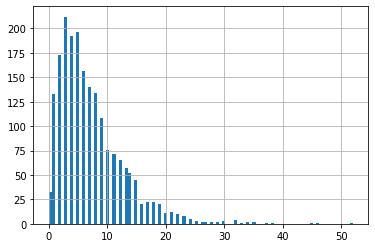

In [41]:
df.token_count.hist(bins = 100)

Let's remove texts that have less than 4 tokens

In [42]:
df = df[df.token_count > 4]
df.reset_index(inplace = True, drop = True)

In [43]:
df[df.token_count > 4].topic.value_counts()

humor              738
science_fiction    520
Name: topic, dtype: int64

## Vectorize the Data

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(df.processed_text)

X is now a sparse matrix of 1258 rows by 4749 columns

In [45]:
X.shape

(1258, 4768)

Transform the topic from string to integer

In [46]:

df.loc[df.topic == 'humor', 'topic' ] = 0
df.loc[df.topic == 'science_fiction', 'topic' ] = 1
df.topic = df.topic.astype(int)
# define the target variable
y = df.topic


In [47]:
y

0       0
1       1
2       1
3       0
4       0
       ..
1253    0
1254    0
1255    1
1256    1
1257    1
Name: topic, Length: 1258, dtype: int64

In [48]:
X

<1258x4768 sparse matrix of type '<class 'numpy.int64'>'
	with 11620 stored elements in Compressed Sparse Row format>

## Train a classifier

In [49]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# 1. Declare the model
clf = MultinomialNB()

# 2. Train the model
clf.fit(X, y)

# 3. Make predictions 
yhat = clf.predict(X)

# 4. score
print("Accuracy: ",accuracy_score(y, yhat))

Accuracy:  0.9888712241653418


To really train a classifier, we need to split the data in two parts: a training subset on which we train the model and a test set on which we evaluate the model. 

The test set simulates data that the model has not seen during its training and gives us a way to measure how the model extrapolates on unseen data.

We need to split the data after we've vectorized the text, otherwise sont tokens may be present in the test set but not in the training set. 

To split the data into a train and a test set we use scikit's [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.



In [50]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)




In [51]:
print(X_train.shape)
print(X_test.shape)

(842, 4768)
(416, 4768)


Let's train the same model, this time on the train set and evaluate it on the test set



In [52]:
# 1. Declare the model
clf = MultinomialNB()

# 2. Train the model
clf.fit(X_train, y_train)

# 3. Make predictions  on test set
yhat = clf.predict(X_test)

# 4. score
print("Accuracy: ",accuracy_score(y_test, yhat))

Accuracy:  0.7740384615384616


The accuracy is down to 77.4% which makes more sense than the outstanding 98% we previously obtained.

# tf-idf

Let's now compare the model performance when we use a tf-idf vectorization approach instead of a simple tf / count vectorizer.

The code is similar and we use scikit's default parameter for [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer()
X = cv.fit_transform(df.processed_text)
y = df.topic

# split test train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# train and evaluate the model
# 1. Declare the model
clf = MultinomialNB()

# 2. Train the model
clf.fit(X_train, y_train)

# 3. Make predictions  on test set
yhat = clf.predict(X_test)

# 4. score
print("Accuracy: ",accuracy_score(y_test, yhat))

Accuracy:  0.7668269230769231


In this particular case, not much difference between the 2 vectorizers. 

# term to term matrix

Here is the code to generate the term to term matrix in chapter 7




In [54]:
from nltk.tokenize import word_tokenize
from itertools import combinations
from collections import Counter

# The corpus
sentences = ['ways to replace the noisy Mac keyboard',
'do you prefer Windows or Mac',
'the Mac has a noisy keyboard',
'ways to install Windows on a Mac',
'you need a Windows license to install Windows on a Mac'
]

# vocab without stopwords
vocab = sorted(list(set(word_tokenize(' '.join(sentences)))))
stopwords = ['a', 'do', 'has', 'in', 'on', 'or', 'the', 'to', 'you', 'your']
vocab = sorted([tk.lower() for tk in vocab if tk not in stopwords])

print('Vocabulary:\n',vocab,'\n')

# tokenize
token_sent_list = [word_tokenize(sen) for sen in sentences]
print('Each sentence in token form:\n',token_sent_list,'\n')

# co occurrence window
k=3

# Definitely not an elegant way to create the term to term matrix
co_occ = {ii:Counter({jj:0 for jj in vocab if jj!=ii}) for ii in vocab}


for sen in token_sent_list:
    sen = [tk.lower() for tk in sen if tk not in stopwords]
    for ii in range(len(sen)):
        if ii < k:
            c = Counter(sen[0:ii+k+1])
            del c[sen[ii]]
            co_occ[sen[ii]] = co_occ[sen[ii]] + c
        elif ii > len(sen)-(k+1):
            c = Counter(sen[ii-k::])
            del c[sen[ii]]
            co_occ[sen[ii]] = co_occ[sen[ii]] + c
        else:
            c = Counter(sen[ii-k:ii+k+1])
            del c[sen[ii]]
            co_occ[sen[ii]] = co_occ[sen[ii]] + c

# Having final matrix in dict form lets you convert it to different python data structures
co_occ = {ii:dict(co_occ[ii]) for ii in vocab}

# convert to DataFrame

df = pd.DataFrame(co_occ)
df.fillna(0, inplace = True)
for c in df.columns:
    df[c] = df[c].astype(int)

# here goes
df


Vocabulary:
 ['install', 'keyboard', 'license', 'mac', 'need', 'noisy', 'prefer', 'replace', 'ways', 'windows'] 

Each sentence in token form:
 [['ways', 'to', 'replace', 'the', 'noisy', 'Mac', 'keyboard'], ['do', 'you', 'prefer', 'Windows', 'or', 'Mac'], ['the', 'Mac', 'has', 'a', 'noisy', 'keyboard'], ['ways', 'to', 'install', 'Windows', 'on', 'a', 'Mac'], ['you', 'need', 'a', 'Windows', 'license', 'to', 'install', 'Windows', 'on', 'a', 'Mac']] 



install  keyboard  license  mac  need  noisy  prefer  replace  ways  \
mac             2         2        1    0     0      2       1        1     2   
ways            1         0        0    2     0      1       0        1     0   
windows         3         0        2    3     1      0       1        0     1   
need            1         0        1    0     0      0       0        0     0   
license         1         0        0    1     1      0       0        0     0   
noisy           0         2        0    2     0      0       0        1     1   
replace         0         1        0    1     0      1       0        0     1   
install         0         0        1    2     1      0       0        0     1   
keyboard        0         0        0    2     0      2       0        1     0   
prefer          0         0        0    1     0      0       0        0     0   

          windows  
mac             3  
ways            1  
windows         0  
need            1  
license         2  
noisy           0  
replace         0  
install         3  
keyboard        0  
prefer          1